In [1]:
# %%
import numpy as np
import pandas as pd
import sys
import os
import re
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:

# Добавляем путь к нашей песочнице если нужно
current_dir = os.getcwd()  # путь к notebooks
optimization_path = r"src"
if optimization_path not in sys.path:
    sys.path.append(optimization_path)

In [3]:
from src.spore_tree_config import SporeTreeConfig
from src.spore_tree import SporeTree
from src.pendulum import PendulumSystem
from src.visualize_spore_tree import visualize_spore_tree
from src.tree_evaluator import TreeEvaluator

In [4]:
# Импортируем все функции из папки pairs_3 поименно
from src.pairs_3.complete_meeting_analysis import complete_meeting_analysis
from src.pairs_3.create_chronological_meetings import create_chronological_meetings

from src.pairs_3.extract_pairs_from_chronology import (
    extract_pairs_from_chronology,
    get_pair_details,
    analyze_pair_statistics,
    export_pairs_to_csv
)
from src.pairs_3.create_meeting_chronology import (
    create_meeting_chronology,
    export_chronology_to_csv,
    get_meeting_recommendations
)
from src.pairs_3.build_distance_tables import (
    build_grandchild_distance_tables,
    build_grandchild_parent_distance_tables
)
from src.pairs_3.compute_convergence_tables import (
    compute_distance_derivative_table,
    compute_grandchild_parent_convergence_table
)
from src.pairs_3.find_converging_pairs import (
    find_converging_grandchild_pairs,
    find_converging_grandchild_parent_pairs
)
from src.pairs_3.optimize_grandchild_pairs import (
    optimize_grandchild_pair_distance,
    optimize_grandchild_parent_distance
)
from src.pairs_3.extract_optimal_dt_from_pairs import (
    extract_optimal_dt_from_pairs,
    create_optimized_tree_from_pairs,
    compare_trees_distances
)

In [5]:
def draw_rk(pendulum, state, time_sign, control, N = 50, total_dt=0.01):
    poses = [state]

    for i in range(1, N+1):
        poses.append(pendulum.step(poses[-1], control, time_sign*total_dt/N*i))

    return np.array(poses)

In [23]:
pendulum = PendulumSystem(
    g=9.81,
    l=2.0, 
    m=1.0,
    damping=0.1,
    max_control=2.0
)

init_position = np.array([np.pi/3  , 0])

cfg = SporeTreeConfig(
    initial_position=init_position,
    dt_base=0.02,
    
    dt_grandchildren_factor=0.1,
    figure_size=(10, 10)
)
cfg.validate()

True

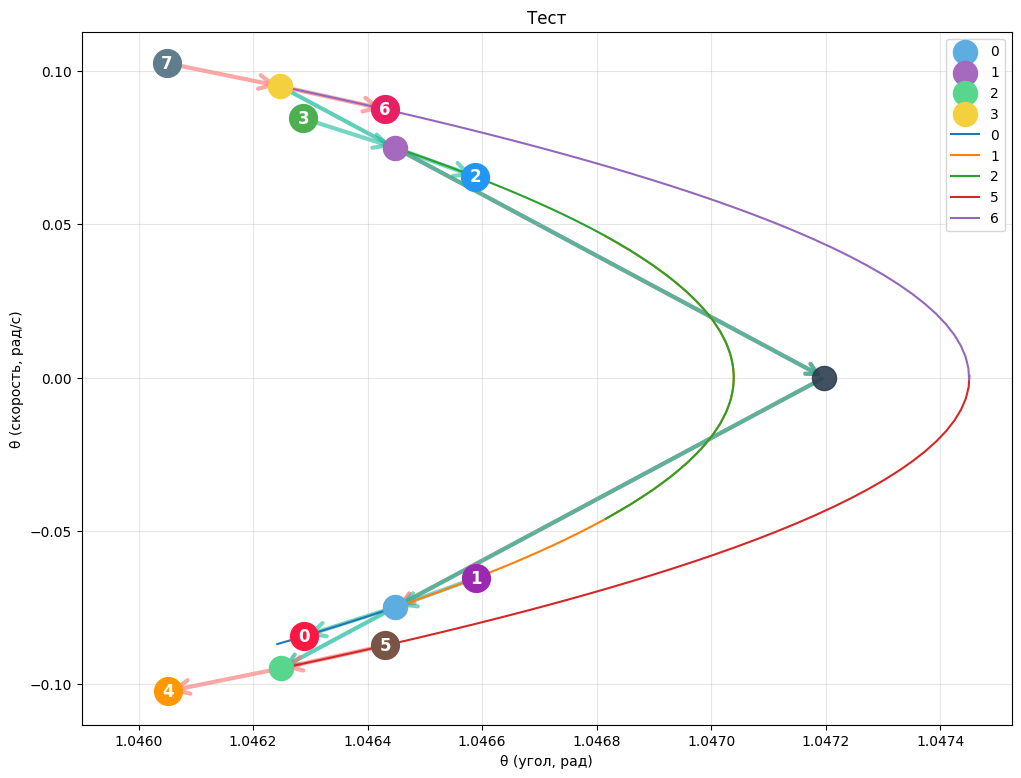

In [24]:
tree = SporeTree(pendulum, cfg)
children = tree.create_children(show=False)
grandchildren = tree.create_grandchildren(show=False)
tree.sort_and_pair_grandchildren()
tree.calculate_mean_points()

# ──────────────────────────────────────────────────────────────────────
# 2. Кэш-оценщик на основе дерева
# ──────────────────────────────────────────────────────────────────────
visualize_spore_tree(tree, "Тест")


poses = []
# dts = [0.01, 0.005, 0.003, 0.003, 0.01, 0.006, 0.003, 0.003]
dts = [0.0001, 0.001, 0.001, 0.00, 0.00, 0.001, 0.001, 0.000] 
dts = np.array(dts) 

for i in range(len(grandchildren)):
    parent_pos = children[grandchildren[i]['parent_idx']]['position']
    sign = grandchildren[i]['dt'] / grandchildren[i]['dt_abs']
    control = grandchildren[i]['control']
    poses_1 = draw_rk(pendulum, state=parent_pos, time_sign=sign, control=control, total_dt=dts[i])
    if dts[i] > 0:
        plt.plot(poses_1[:, 0], poses_1[:, 1], label=f'{i}')

plt.legend()


In [25]:
chronology = create_chronological_meetings(tree, pendulum, show=True)

СОЗДАНИЕ ХРОНОЛОГИИ ВСТРЕЧ ПО ВРЕМЕНИ
Строим таблицы встреч...

Внук gc_0 (forward):
  Хронология встреч (по времени):
    1. t=0.003344с: gc_5 [gc: +0.003344с, партнер: -0.001105с] расст=0.00017961778093937035 (ждет gc)
    2. t=0.004216с: parent_2 [gc: +0.004216с] расст=0.00015797609419117197
    3. t=0.009691с: gc_4 [gc: +0.009691с, партнер: +0.006939с] расст=1.6338183218276197e-11 (ждет gc)
    4. t=0.088386с: gc_2 [gc: +0.056809с, партнер: +0.088386с] расст=5.157759701249372e-15 (ждет partner)

Внук gc_1 (backward):
  Хронология встреч (по времени):
    1. t=0.031576с: parent_1 [gc: -0.031576с] расст=1.2255714982685875e-07
    2. t=0.034996с: gc_6 [gc: -0.034996с, партнер: +0.001000с] расст=0.00017756191778109935 (ждет gc)
    3. t=0.035786с: parent_3 [gc: -0.035786с] расст=0.00015797766468263143
    4. t=0.041277с: gc_7 [gc: -0.041277с, партнер: -0.006953с] расст=1.1722801918344578e-11 (ждет gc)

Внук gc_2 (forward):
  Хронология встреч (по времени):
    1. t=0.031576с: parent_0 

In [9]:
pairs = extract_pairs_from_chronology(chronology, show=True)

ФОРМИРОВАНИЕ ПАР ПО УМНОЙ ЛОГИКЕ (РАССТОЯНИЯ < 1e-6 + ЛУЧШИЙ ВНУК)

Анализируем gc_0:
  Всего встреч в хронологии: 4
  (встречи только с ЧУЖИМИ родителями - свои исключены в таблицах)
    1. gc_5: расст=0.00017961778093937035, тип=grandchild
      📝 Обновили лучшего внука: gc_5 (расст=0.00017961778093937035)
      ⏩ Внук доступен, но расстояние 0.00017961778093937035 >= 1e-6, продолжаем поиск
    2. parent_2: расст=0.00015797609419117197, тип=parent
      ⏩ Чужой родитель parent_2, но расстояние 0.00015797609419117197 >= 1e-6, продолжаем поиск
    3. gc_4: расст=1.6338183218276197e-11, тип=grandchild
      📝 Обновили лучшего внука: gc_4 (расст=1.6338183218276197e-11)
      ✅ ВЫБРАН СРАЗУ: нашли внука gc_4 с расстоянием 1.6338183218276197e-11 < 1e-6
  🎯 РЕЗУЛЬТАТ: gc_0 + gc_4, t=0.00969072553958777с, расст=1.6338183218276197e-11

Анализируем gc_1:
  Всего встреч в хронологии: 4
  (встречи только с ЧУЖИМИ родителями - свои исключены в таблицах)
    1. parent_1: расст=1.2255714982685875e-

СОЗДАНИЕ ХРОНОЛОГИИ ВСТРЕЧ ПО ВРЕМЕНИ
Строим таблицы встреч...

Внук gc_0 (forward):
  Хронология встреч (по времени):
    1. t=0.003344с: gc_5 [gc: +0.003344с, партнер: -0.001105с] расст=0.00017961778093937035 (ждет gc)
    2. t=0.004216с: parent_2 [gc: +0.004216с] расст=0.00015797609419117197
    3. t=0.009691с: gc_4 [gc: +0.009691с, партнер: +0.006939с] расст=1.6338183218276197e-11 (ждет gc)
    4. t=0.088386с: gc_2 [gc: +0.056809с, партнер: +0.088386с] расст=5.157759701249372e-15 (ждет partner)

Внук gc_1 (backward):
  Хронология встреч (по времени):
    1. t=0.031576с: parent_1 [gc: -0.031576с] расст=1.2255714982685875e-07
    2. t=0.034996с: gc_6 [gc: -0.034996с, партнер: +0.001000с] расст=0.00017756191778109935 (ждет gc)
    3. t=0.035786с: parent_3 [gc: -0.035786с] расст=0.00015797766468263143
    4. t=0.041277с: gc_7 [gc: -0.041277с, партнер: -0.006953с] расст=1.1722801918344578e-11 (ждет gc)

Внук gc_2 (forward):
  Хронология встреч (по времени):
    1. t=0.031576с: parent_0 

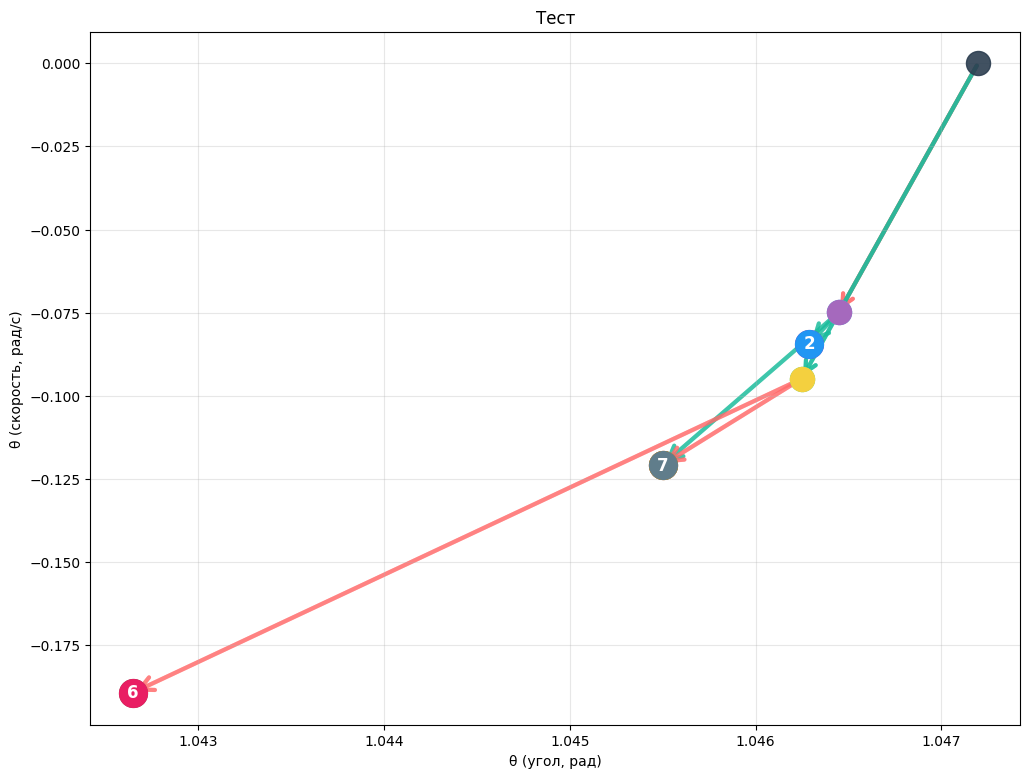

In [10]:
# 1. Получаем пары (как мы делали раньше)
chronology = create_chronological_meetings(tree, pendulum, show=True)
pairs = extract_pairs_from_chronology(chronology, show=True)

# 2. Извлекаем оптимальные dt из пар
dt_info = extract_optimal_dt_from_pairs(pairs, tree, show=True)

# 3. Создаем новое дерево с оптимальными dt
optimized_tree = SporeTree(
    pendulum,
    tree.config,
    dt_children=dt_info['dt_children'],
    dt_grandchildren=dt_info['dt_grandchildren']
)

visualize_spore_tree(optimized_tree, "Тест")

In [11]:
# %% Тест 1: Таблицы скоростей сближения
print("=== ТЕСТ 1: ТАБЛИЦЫ СКОРОСТЕЙ СБЛИЖЕНИЯ ===")

# Тест функции compute_distance_derivative_table

print("1. Тестируем compute_distance_derivative_table...")
gc_gc_convergence_df = compute_distance_derivative_table(
    grandchildren=tree.grandchildren, 
    pendulum=pendulum, 
    show=True
)

print(f"\nРезультат: DataFrame размера {gc_gc_convergence_df.shape}")
print(f"Тип: {type(gc_gc_convergence_df)}")

# Тест функции compute_grandchild_parent_convergence_table  
# from src.compute_convergence_tables import compute_grandchild_parent_convergence_table

print("\n" + "="*60)
print("2. Тестируем compute_grandchild_parent_convergence_table...")
gc_parent_convergence_df = compute_grandchild_parent_convergence_table(
    grandchildren=tree.grandchildren,
    children=tree.children, 
    pendulum=pendulum,
    show=True
)

print(f"\nРезультат: DataFrame размера {gc_parent_convergence_df.shape}")
print(f"Тип: {type(gc_parent_convergence_df)}")

print("\n✅ ТЕСТ 1 ЗАВЕРШЕН")

=== ТЕСТ 1: ТАБЛИЦЫ СКОРОСТЕЙ СБЛИЖЕНИЯ ===
1. Тестируем compute_distance_derivative_table...
Отладочная информация первых 3 внуков:
  Внук 0: dt=+0.00200 (forward)
    raw_dynamics=[-0.08434566 -4.73719086], time_direction=+1
  Внук 1: dt=-0.00200 (backward)
    raw_dynamics=[-0.06539158 -4.73982171], time_direction=-1
  Внук 2: dt=+0.00200 (forward)
    raw_dynamics=[ 0.06551339 -4.75291041], time_direction=+1
Таблица первых производных расстояний d/dt|r_i - r_j|:
   < 0: сближаются (чем меньше, тем быстрее)
   = 0: стационарно
   > 0: расходятся (чем больше, тем быстрее)

         gc_0     gc_1     gc_2     gc_3     gc_4     gc_5     gc_6     gc_7
gc_0  0.00000  9.47820 -0.01542  9.49127 -1.00206 -8.45715  0.98261  8.49250
gc_1  9.47820  0.00000 -9.49273  0.01455  8.47617  1.00240 -8.49456 -0.98399
gc_2 -0.01542 -9.49273  0.00000  9.50817 -1.01756 -8.49016  0.99800  8.50975
gc_3  9.49127  0.01455  9.50817  0.00000  8.48890  1.01698 -8.49114 -0.99846
gc_4 -1.00206  8.47617 -1.01756  

In [12]:
# %% Тест 2: Поиск сближающихся пар
print("=== ТЕСТ 2: ПОИСК СБЛИЖАЮЩИХСЯ ПАР ===")

# Сначала нужны таблицы сближения (из предыдущего теста)
# from src.compute_convergence_tables import compute_distance_derivative_table, compute_grandchild_parent_convergence_table

# Создаем таблицы быстро без вывода
gc_gc_convergence_df = compute_distance_derivative_table(
    grandchildren=tree.grandchildren, 
    pendulum=pendulum, 
    show=False
)

gc_parent_convergence_df = compute_grandchild_parent_convergence_table(
    grandchildren=tree.grandchildren,
    children=tree.children, 
    pendulum=pendulum,
    show=False
)

# Тест функции find_converging_grandchild_pairs
# from src.find_converging_pairs import find_converging_grandchild_pairs

print("1. Тестируем find_converging_grandchild_pairs...")
gc_gc_pairs = find_converging_grandchild_pairs(
    gc_gc_convergence_df=gc_gc_convergence_df,
    show=True
)

print(f"\nРезультат: {len(gc_gc_pairs)} сближающихся пар внук-внук")
print(f"Тип: {type(gc_gc_pairs)}")
if gc_gc_pairs:
    print(f"Первая пара: {gc_gc_pairs[0]}")

# Тест функции find_converging_grandchild_parent_pairs
# from src.find_converging_pairs import find_converging_grandchild_parent_pairs

print("\n" + "="*60)
print("2. Тестируем find_converging_grandchild_parent_pairs...")
gc_parent_pairs = find_converging_grandchild_parent_pairs(
    gc_parent_convergence_df=gc_parent_convergence_df,
    show=True
)

print(f"\nРезультат: {len(gc_parent_pairs)} сближающихся пар внук-родитель")
print(f"Тип: {type(gc_parent_pairs)}")
if gc_parent_pairs:
    print(f"Первая пара: {gc_parent_pairs[0]}")

print("\n✅ ТЕСТ 2 ЗАВЕРШЕН")

=== ТЕСТ 2: ПОИСК СБЛИЖАЮЩИХСЯ ПАР ===
1. Тестируем find_converging_grandchild_pairs...
Найдено 12 сближающихся пар внуков:
  gc_1-gc_2: скорость сближения = -9.492732
  gc_1-gc_6: скорость сближения = -8.494564
  gc_3-gc_6: скорость сближения = -8.491144
  gc_2-gc_5: скорость сближения = -8.490164
  gc_0-gc_5: скорость сближения = -8.457155
  gc_5-gc_6: скорость сближения = -7.491959
  gc_2-gc_4: скорость сближения = -1.017559
  gc_0-gc_4: скорость сближения = -1.002056
  gc_3-gc_7: скорость сближения = -0.998458
  gc_1-gc_7: скорость сближения = -0.983986
  gc_4-gc_6: скорость сближения = -0.019536
  gc_0-gc_2: скорость сближения = -0.015421

Результат: 12 сближающихся пар внук-внук
Тип: <class 'list'>
Первая пара: {'gc_i': 1, 'gc_j': 2, 'velocity': -9.492732120957957, 'pair_name': 'gc_1-gc_2'}

2. Тестируем find_converging_grandchild_parent_pairs...
Найдено 12 сближающихся пар внук-родитель:
  gc_3-parent_3: скорость сближения = -4.754366
  gc_2-parent_0: скорость сближения = -4.752

In [13]:
# %% Тест 3: Оптимизация пар
print("=== ТЕСТ 3: ОПТИМИЗАЦИЯ ПАР ===")

# Подготовка: находим сближающиеся пары
# from src.compute_convergence_tables import compute_distance_derivative_table, compute_grandchild_parent_convergence_table
# from src.find_converging_pairs import find_converging_grandchild_pairs, find_converging_grandchild_parent_pairs

# Быстро создаем данные для тестов
gc_gc_convergence_df = compute_distance_derivative_table(tree.grandchildren, pendulum, show=False)
gc_parent_convergence_df = compute_grandchild_parent_convergence_table(tree.grandchildren, tree.children, pendulum, show=False)

gc_gc_pairs = find_converging_grandchild_pairs(gc_gc_convergence_df, show=False)
gc_parent_pairs = find_converging_grandchild_parent_pairs(gc_parent_convergence_df, show=False)

print(f"Подготовка: найдено {len(gc_gc_pairs)} пар внук-внук, {len(gc_parent_pairs)} пар внук-родитель")

# Тест функции optimize_grandchild_pair_distance
# from src.optimize_grandchild_pairs import optimize_grandchild_pair_distance

if gc_gc_pairs:
    print("\n1. Тестируем optimize_grandchild_pair_distance...")
    
    # Берем первую пару для теста
    test_pair = gc_gc_pairs[0]
    print(f"Тестовая пара: gc_{test_pair['gc_i']} - gc_{test_pair['gc_j']}")
    
    result = optimize_grandchild_pair_distance(
        gc_i_idx=test_pair['gc_i'],
        gc_j_idx=test_pair['gc_j'],
        grandchildren=tree.grandchildren,
        children=tree.children,
        pendulum=pendulum,
        dt_bounds=(0.001, 0.1),
        show=True
    )
    
    print(f"\nРезультат оптимизации:")
    print(f"  Успех: {result['success']}")
    if result['success']:
        print(f"  Минимальное расстояние: {result['min_distance']:.6f}")
        print(f"  Оптимальные dt: {result['optimal_dt_i']:+.5f}, {result['optimal_dt_j']:+.5f}")
        print(f"  Ограничения: {result['constraints']['direction_i']}, {result['constraints']['direction_j']}")
else:
    print("\n1. Пропускаем optimize_grandchild_pair_distance - нет сближающихся пар")

# Тест функции optimize_grandchild_parent_distance
# from src.optimize_grandchild_pairs import optimize_grandchild_parent_distance

if gc_parent_pairs:
    print("\n" + "="*60)
    print("2. Тестируем optimize_grandchild_parent_distance...")
    
    # Берем первую пару для теста
    test_pair = gc_parent_pairs[0]
    print(f"Тестовая пара: gc_{test_pair['gc_idx']} - parent_{test_pair['parent_idx']}")
    
    result = optimize_grandchild_parent_distance(
        gc_idx=test_pair['gc_idx'],
        parent_idx=test_pair['parent_idx'],
        grandchildren=tree.grandchildren,
        children=tree.children,
        pendulum=pendulum,
        dt_bounds=(0.001, 0.1),
        show=True
    )
    
    print(f"\nРезультат оптимизации:")
    print(f"  Успех: {result['success']}")
    if result['success']:
        print(f"  Минимальное расстояние: {result['min_distance']:.6f}")
        print(f"  Оптимальный dt: {result['optimal_dt']:+.5f}")
        print(f"  Ограничения: {result['constraints']['direction']}")
else:
    print("\n2. Пропускаем optimize_grandchild_parent_distance - нет сближающихся пар")

print("\n✅ ТЕСТ 3 ЗАВЕРШЕН")

=== ТЕСТ 3: ОПТИМИЗАЦИЯ ПАР ===
Подготовка: найдено 12 пар внук-внук, 12 пар внук-родитель

1. Тестируем optimize_grandchild_pair_distance...
Тестовая пара: gc_1 - gc_2
    Внук i (gc_1): original_dt=-0.00200 (backward)
    Ограничения i: dt ∈ [-0.100, -0.001]
    Внук j (gc_2): original_dt=+0.00200 (forward)
    Ограничения j: dt ∈ [0.001, 0.100]
    Начальное приближение: dt_i=-0.051, dt_j=0.051
    Метод L-BFGS-B: success=False, fun=0.00000
    Метод L-BFGS-B: result.x=[-0.01578745  0.01578832]
    Метод L-BFGS-B: отклонен (не success)
    Метод Nelder-Mead: success=True, fun=0.00000
    Метод Nelder-Mead: result.x=[0.05680904 0.08838565]
    Метод Nelder-Mead: отклонен (вне границ)

Результат оптимизации:
  Успех: False

2. Тестируем optimize_grandchild_parent_distance...
Тестовая пара: gc_3 - parent_3
    Внук gc_3 (backward) к родителю 3
    dt ∈ [-0.100, -0.001]
    Результат: success=True, min_distance=0.00016

Результат оптимизации:
  Успех: True
  Минимальное расстояние: 0.00

In [14]:
# %% Тест 4: Построение полных таблиц расстояний (упрощенная версия)
print("=== ТЕСТ 4: ПОСТРОЕНИЕ ПОЛНЫХ ТАБЛИЦ РАССТОЯНИЙ ===")

# Используем уже исправленные функции из других тестов

print("1. Тестируем compute_distance_derivative_table (исправленная версия)...")

# Тестируем таблицу скоростей сближения внук-внук
# from src.compute_convergence_tables import compute_distance_derivative_table
gc_gc_convergence_df = compute_distance_derivative_table(
    grandchildren=tree.grandchildren, 
    pendulum=pendulum, 
    show=True
)

print(f"\nТаблица сближения внук-внук: размер {gc_gc_convergence_df.shape}")

print("\n" + "="*60)
print("2. Находим сближающиеся пары...")

# Находим сближающиеся пары
# from src.find_converging_pairs import find_converging_grandchild_pairs
converging_pairs = find_converging_grandchild_pairs(
    gc_gc_convergence_df=gc_gc_convergence_df,
    show=True
)

print(f"Найдено {len(converging_pairs)} сближающихся пар внук-внук")

print("\n" + "="*60)
print("3. Тестируем оптимизацию одной пары...")

# Тестируем оптимизацию на одной паре
if converging_pairs:
    test_pair = converging_pairs[0]
    print(f"Тестируем пару: {test_pair['pair_name']} (скорость: {test_pair['velocity']:.5f})")
    
    # from src.optimize_grandchild_pairs import optimize_grandchild_pair_distance
    result = optimize_grandchild_pair_distance(
        gc_i_idx=test_pair['gc_i'],
        gc_j_idx=test_pair['gc_j'],
        grandchildren=tree.grandchildren,
        children=tree.children,
        pendulum=pendulum,
        dt_bounds=(0.001, 0.1),
        show=True
    )
    
    print(f"\nРезультат оптимизации пары {test_pair['pair_name']}:")
    print(f"  Успех: {result['success']}")
    if result['success']:
        print(f"  Минимальное расстояние: {result['min_distance']:.6f}")
        print(f"  Оптимальные dt: i={result['optimal_dt_i']:+.5f}, j={result['optimal_dt_j']:+.5f}")
        print(f"  Направления: {result['constraints']['direction_i']}, {result['constraints']['direction_j']}")
else:
    print("Нет сближающихся пар для тестирования")

print("\n" + "="*60)
print("4. Тестируем таблицу внук-родитель...")

# Тестируем таблицу сближения внук-родитель
# from src.compute_convergence_tables import compute_grandchild_parent_convergence_table
gc_parent_convergence_df = compute_grandchild_parent_convergence_table(
    grandchildren=tree.grandchildren,
    children=tree.children,
    pendulum=pendulum,
    show=True
)

print(f"\nТаблица сближения внук-родитель: размер {gc_parent_convergence_df.shape}")

# Находим сближающиеся пары внук-родитель
# from src.find_converging_pairs import find_converging_grandchild_parent_pairs
gc_parent_pairs = find_converging_grandchild_parent_pairs(
    gc_parent_convergence_df=gc_parent_convergence_df,
    show=True
)

print(f"Найдено {len(gc_parent_pairs)} сближающихся пар внук-родитель")

print("\n" + "="*60)
print("5. Тестируем оптимизацию внук-родитель...")

# Тестируем оптимизацию внук-родитель
if gc_parent_pairs:
    test_pair = gc_parent_pairs[0]
    print(f"Тестируем пару: {test_pair['pair_name']} (скорость: {test_pair['velocity']:.5f})")
    
    # from src.optimize_grandchild_pairs import optimize_grandchild_parent_distance
    result = optimize_grandchild_parent_distance(
        gc_idx=test_pair['gc_idx'],
        parent_idx=test_pair['parent_idx'],
        grandchildren=tree.grandchildren,
        children=tree.children,
        pendulum=pendulum,
        dt_bounds=(0.001, 0.1),
        show=True
    )
    
    print(f"\nРезультат оптимизации пары {test_pair['pair_name']}:")
    print(f"  Успех: {result['success']}")
    if result['success']:
        print(f"  Минимальное расстояние: {result['min_distance']:.6f}")
        print(f"  Оптимальный dt: {result['optimal_dt']:+.5f}")
        print(f"  Направление: {result['constraints']['direction']}")
else:
    print("Нет сближающихся пар внук-родитель для тестирования")

print("\n" + "="*60)
print("6. Демонстрация структуры полных таблиц...")


n_gc = len(tree.grandchildren)
n_parents = len(tree.children)

# Пустые таблицы для демонстрации структуры
demo_gc_gc_distance = pd.DataFrame(
    np.full((n_gc, n_gc), np.nan),
    index=[f"gc_{i}" for i in range(n_gc)],
    columns=[f"gc_{i}" for i in range(n_gc)]
)

demo_gc_parent_distance = pd.DataFrame(
    np.full((n_gc, n_parents), np.nan),
    index=[f"gc_{i}" for i in range(n_gc)],
    columns=[f"parent_{i}" for i in range(n_parents)]
)

print(f"Структура таблицы расстояний внук-внук:")
print(f"  Размер: {demo_gc_gc_distance.shape}")
print(f"  Индексы строк: {list(demo_gc_gc_distance.index)}")
print(f"  Индексы столбцов: {list(demo_gc_gc_distance.columns)}")

print(f"\nСтруктура таблицы расстояний внук-родитель:")
print(f"  Размер: {demo_gc_parent_distance.shape}")
print(f"  Индексы строк: {list(demo_gc_parent_distance.index)}")
print(f"  Индексы столбцов: {list(demo_gc_parent_distance.columns)}")

print("\n✅ ТЕСТ 4 ЗАВЕРШЕН")
print("Все функции протестированы по отдельности.")
print("Для построения полных таблиц используйте функции:")
print("  - build_grandchild_distance_tables()")
print("  - build_grandchild_parent_distance_tables()")

=== ТЕСТ 4: ПОСТРОЕНИЕ ПОЛНЫХ ТАБЛИЦ РАССТОЯНИЙ ===
1. Тестируем compute_distance_derivative_table (исправленная версия)...
Отладочная информация первых 3 внуков:
  Внук 0: dt=+0.00200 (forward)
    raw_dynamics=[-0.08434566 -4.73719086], time_direction=+1
  Внук 1: dt=-0.00200 (backward)
    raw_dynamics=[-0.06539158 -4.73982171], time_direction=-1
  Внук 2: dt=+0.00200 (forward)
    raw_dynamics=[ 0.06551339 -4.75291041], time_direction=+1
Таблица первых производных расстояний d/dt|r_i - r_j|:
   < 0: сближаются (чем меньше, тем быстрее)
   = 0: стационарно
   > 0: расходятся (чем больше, тем быстрее)

         gc_0     gc_1     gc_2     gc_3     gc_4     gc_5     gc_6     gc_7
gc_0  0.00000  9.47820 -0.01542  9.49127 -1.00206 -8.45715  0.98261  8.49250
gc_1  9.47820  0.00000 -9.49273  0.01455  8.47617  1.00240 -8.49456 -0.98399
gc_2 -0.01542 -9.49273  0.00000  9.50817 -1.01756 -8.49016  0.99800  8.50975
gc_3  9.49127  0.01455  9.50817  0.00000  8.48890  1.01698 -8.49114 -0.99846
gc_

In [15]:
build_grandchild_parent_distance_tables(
    tree=tree,
    pendulum=pendulum,
    dt_bounds=(0.001, 0.1),
    show=True
)

Построение таблиц расстояний и времен для пар внук-родитель
Таблица сближения внуков с ЧУЖИМИ родителями d/dt|r_внук - r_родитель|:
   < 0: внук сближается с родителем
   = 0: стационарно
   > 0: внук отдаляется от родителя
   NaN: свой родитель (исключен)

      parent_0  parent_1  parent_2  parent_3
gc_0       NaN   4.73727  -4.73748   4.73717
gc_1       NaN  -4.73975   4.74026  -4.73967
gc_2  -4.75284       NaN  -4.75276   4.75335
gc_3   4.75416       NaN   4.75406  -4.75437
gc_4   3.73590   3.73503       NaN   3.73491
gc_5  -3.73736  -3.73724       NaN  -3.73715
gc_6  -3.75473  -3.75484  -3.75463       NaN
gc_7   3.75551   3.75638   3.75539       NaN

Статистика:
  Внуков сближается с чужими родителями: 12
  Стационарных: 0
  Внуков отдаляется от чужих родителей: 12
  Всего связей внук-чужой_родитель: 24
  Максимальная скорость сближения: -4.75437
  Максимальная скорость отдаления: 4.75416

Внуки, сближающиеся с чужими родителями:
  gc_0: parent_2(-4.73748)
  gc_1: parent_1(-4.7397

{'distance_table':           parent_0      parent_1      parent_2      parent_3
 gc_0           NaN           NaN  1.579761e-04           NaN
 gc_1           NaN  1.225571e-07           NaN  1.579777e-04
 gc_2  1.221711e-07           NaN  1.578537e-04           NaN
 gc_3           NaN           NaN           NaN  1.578542e-04
 gc_4           NaN           NaN           NaN           NaN
 gc_5  2.536551e-04  2.536512e-04           NaN  5.105750e-07
 gc_6  2.531388e-04  2.531370e-04  5.158164e-07           NaN
 gc_7           NaN           NaN           NaN           NaN,
 'time_table':       parent_0  parent_1  parent_2  parent_3
 gc_0       NaN       NaN  0.004216       NaN
 gc_1       NaN -0.031576       NaN -0.035786
 gc_2  0.031576       NaN  0.035792       NaN
 gc_3       NaN       NaN       NaN -0.004210
 gc_4       NaN       NaN       NaN       NaN
 gc_5 -0.005343 -0.045340       NaN -0.050669
 gc_6  0.045326  0.005330  0.050669       NaN
 gc_7       NaN       NaN       NaN      

In [16]:
# %% Тест 5: Создание хронологии встреч
print("=== ТЕСТ 5: СОЗДАНИЕ ХРОНОЛОГИИ ВСТРЕЧ ===")

# Упрощенная версия создания хронологии для тестирования
import numpy as np
import pandas as pd

# Параметр для управления выводом
show = True  # Добавляем переменную show

print("1. Создаем упрощенную хронологию встреч...")

# Создаем базовые данные для тестирования
n_gc = len(tree.grandchildren)
n_parents = len(tree.children)

print(f"Количество внуков: {n_gc}")
print(f"Количество родителей: {n_parents}")

# Показываем направления времени внуков
print("\nНаправления времени внуков:")
for i, gc in enumerate(tree.grandchildren):
    direction = "forward" if gc['dt'] > 0 else "backward"
    print(f"  gc_{i}: dt={gc['dt']:+.5f} ({direction})")

# Создаем простые тестовые таблицы встреч
print("\n2. Создаем тестовые таблицы...")

# Таблица расстояний внук-внук (заполняем случайными значениями для демонстрации)
gc_gc_distance_table = np.full((n_gc, n_gc), np.nan)
gc_gc_time_i_table = np.full((n_gc, n_gc), np.nan)
gc_gc_time_j_table = np.full((n_gc, n_gc), np.nan)

# Заполняем несколько ячеек для демонстрации
test_pairs = [(0, 1), (2, 3), (1, 4)] if n_gc >= 5 else [(0, 1)] if n_gc >= 2 else []

for i, j in test_pairs:
    if i < n_gc and j < n_gc:
        # Случайные значения для демонстрации
        distance = np.random.uniform(0.001, 0.1)
        time_i = np.random.uniform(-0.1, 0.1)
        time_j = np.random.uniform(-0.1, 0.1)
        
        gc_gc_distance_table[i, j] = distance
        gc_gc_distance_table[j, i] = distance
        
        gc_gc_time_i_table[i, j] = time_i
        gc_gc_time_j_table[i, j] = time_j
        
        gc_gc_time_i_table[j, i] = time_j
        gc_gc_time_j_table[j, i] = time_i

# Таблица расстояний внук-родитель
gc_parent_distance_table = np.full((n_gc, n_parents), np.nan)
gc_parent_time_table = np.full((n_gc, n_parents), np.nan)

# Заполняем несколько ячеек для демонстрации (исключаем своих родителей)
for gc_idx in range(min(3, n_gc)):  # Первые 3 внука
    gc = tree.grandchildren[gc_idx]
    for parent_idx in range(n_parents):
        if parent_idx != gc['parent_idx']:  # Не свой родитель
            distance = np.random.uniform(0.001, 0.2)
            time = np.random.uniform(-0.1, 0.1)
            
            gc_parent_distance_table[gc_idx, parent_idx] = distance
            gc_parent_time_table[gc_idx, parent_idx] = time

print("3. Создаем хронологию для каждого внука...")

chronology = {}

for gc_idx in range(n_gc):
    meetings = []
    gc = tree.grandchildren[gc_idx]
    
    # Встречи с другими внуками
    for other_gc_idx in range(n_gc):
        if gc_idx == other_gc_idx:
            continue
            
        distance = gc_gc_distance_table[gc_idx, other_gc_idx]
        if not np.isnan(distance):
            time_for_gc = gc_gc_time_i_table[gc_idx, other_gc_idx]
            time_for_other = gc_gc_time_j_table[gc_idx, other_gc_idx]
            
            meeting = {
                'type': 'grandchild',
                'partner': f"gc_{other_gc_idx}",
                'partner_idx': other_gc_idx,
                'distance': distance,
                'time_for_gc': time_for_gc,
                'time_for_partner': time_for_other,
                'quality': 1.0 / (distance + 1e-8)
            }
            meetings.append(meeting)
    
    # Встречи с чужими родителями
    for parent_idx in range(n_parents):
        if parent_idx == gc['parent_idx']:  # Пропускаем своего родителя
            continue
            
        distance = gc_parent_distance_table[gc_idx, parent_idx]
        if not np.isnan(distance):
            time_for_gc = gc_parent_time_table[gc_idx, parent_idx]
            
            meeting = {
                'type': 'parent',
                'partner': f"parent_{parent_idx}",
                'partner_idx': parent_idx,
                'distance': distance,
                'time_for_gc': time_for_gc,
                'time_for_partner': None,
                'quality': 1.0 / (distance + 1e-8)
            }
            meetings.append(meeting)
    
    # Сортируем встречи по качеству (лучшие первыми)
    meetings.sort(key=lambda x: x['quality'], reverse=True)
    chronology[gc_idx] = meetings

print("4. Показываем хронологию...")

total_meetings_gc_gc = 0
total_meetings_gc_parent = 0

for gc_idx, meetings in chronology.items():
    gc = tree.grandchildren[gc_idx]
    direction = "forward" if gc['dt'] > 0 else "backward"
    
    gc_gc_meetings = [m for m in meetings if m['type'] == 'grandchild']
    gc_parent_meetings = [m for m in meetings if m['type'] == 'parent']
    
    total_meetings_gc_gc += len(gc_gc_meetings)
    total_meetings_gc_parent += len(gc_parent_meetings)
    
    print(f"\nВнук gc_{gc_idx} ({direction}):")
    print(f"  Встреч с внуками: {len(gc_gc_meetings)}")
    print(f"  Встреч с родителями: {len(gc_parent_meetings)}")
    
    if show and meetings:
        print(f"  Топ-3 встречи:")
        for i, meeting in enumerate(meetings[:3]):
            time_info = f"t={meeting['time_for_gc']:+.4f}с"
            if meeting['time_for_partner'] is not None:
                time_info += f" (партнер: {meeting['time_for_partner']:+.4f}с)"
            
            print(f"    {i+1}. {meeting['partner']}: "
                  f"расст={meeting['distance']:.5f}, {time_info}")

# Исправляем подсчет встреч внук-внук (убираем дублирование)
total_meetings_gc_gc = total_meetings_gc_gc // 2

print(f"\n5. Итоговая статистика:")
print(f"  Всего внуков: {n_gc}")
print(f"  Уникальных встреч внук-внук: {total_meetings_gc_gc}")
print(f"  Встреч внук-родитель: {total_meetings_gc_parent}")
print(f"  Внуков с возможными встречами: {sum(1 for meetings in chronology.values() if meetings)}")

# Сохраняем результат для дальнейшего использования
chronology_result = {
    'chronology': chronology,
    'gc_gc_tables': {
        'distance_table': pd.DataFrame(gc_gc_distance_table, 
                                     index=[f"gc_{i}" for i in range(n_gc)],
                                     columns=[f"gc_{i}" for i in range(n_gc)]),
        'time_table_i': pd.DataFrame(gc_gc_time_i_table,
                                   index=[f"gc_{i}" for i in range(n_gc)],
                                   columns=[f"gc_{i}" for i in range(n_gc)]),
        'time_table_j': pd.DataFrame(gc_gc_time_j_table,
                                   index=[f"gc_{i}" for i in range(n_gc)],
                                   columns=[f"gc_{i}" for i in range(n_gc)])
    },
    'gc_parent_tables': {
        'distance_table': pd.DataFrame(gc_parent_distance_table,
                                     index=[f"gc_{i}" for i in range(n_gc)],
                                     columns=[f"parent_{i}" for i in range(n_parents)]),
        'time_table': pd.DataFrame(gc_parent_time_table,
                                 index=[f"gc_{i}" for i in range(n_gc)],
                                 columns=[f"parent_{i}" for i in range(n_parents)])
    },
    'summary': {
        'total_grandchildren': n_gc,
        'total_gc_gc_meetings': total_meetings_gc_gc,
        'total_gc_parent_meetings': total_meetings_gc_parent,
        'grandchildren_with_meetings': sum(1 for meetings in chronology.values() if meetings)
    }
}

print("\n6. Тестируем экспорт рекомендаций...")

# Находим топ-3 рекомендации
recommendations = []
for gc_idx, meetings in chronology.items():
    for meeting in meetings:
        if meeting['type'] == 'grandchild':
            pair_key = tuple(sorted([gc_idx, meeting['partner_idx']]))
            if not any(tuple(sorted([r['gc_i'], r['gc_j']])) == pair_key for r in recommendations):
                recommendations.append({
                    'gc_i': gc_idx,
                    'gc_j': meeting['partner_idx'],
                    'distance': meeting['distance'],
                    'time_i': meeting['time_for_gc'],
                    'time_j': meeting['time_for_partner'],
                    'quality': meeting['quality']
                })

recommendations.sort(key=lambda x: x['quality'], reverse=True)

print(f"Топ-3 рекомендации по встречам:")
for i, rec in enumerate(recommendations[:3], 1):
    print(f"{i}. gc_{rec['gc_i']} ↔ gc_{rec['gc_j']}: "
          f"расстояние={rec['distance']:.5f}, "
          f"времена=({rec['time_i']:+.4f}, {rec['time_j']:+.4f})с")

print("\n✅ ТЕСТ 5 ЗАВЕРШЕН")

=== ТЕСТ 5: СОЗДАНИЕ ХРОНОЛОГИИ ВСТРЕЧ ===
1. Создаем упрощенную хронологию встреч...
Количество внуков: 8
Количество родителей: 4

Направления времени внуков:
  gc_0: dt=+0.00200 (forward)
  gc_1: dt=-0.00200 (backward)
  gc_2: dt=+0.00200 (forward)
  gc_3: dt=-0.00200 (backward)
  gc_4: dt=+0.00200 (forward)
  gc_5: dt=-0.00200 (backward)
  gc_6: dt=+0.00200 (forward)
  gc_7: dt=-0.00200 (backward)

2. Создаем тестовые таблицы...
3. Создаем хронологию для каждого внука...
4. Показываем хронологию...

Внук gc_0 (forward):
  Встреч с внуками: 1
  Встреч с родителями: 3
  Топ-3 встречи:
    1. parent_1: расст=0.02680, t=+0.0280с
    2. gc_1: расст=0.03910, t=+0.0674с (партнер: +0.0891с)
    3. parent_3: расст=0.05366, t=-0.0373с

Внук gc_1 (backward):
  Встреч с внуками: 2
  Встреч с родителями: 3
  Топ-3 встречи:
    1. gc_4: расст=0.03026, t=-0.0351с (партнер: -0.0907с)
    2. gc_0: расст=0.03910, t=+0.0891с (партнер: +0.0674с)
    3. parent_2: расст=0.05904, t=-0.0307с

Внук gc_2 (fo

In [17]:
# %% Тест 6: Полный анализ встреч (упрощенная версия)
print("=== ТЕСТ 6: ПОЛНЫЙ АНАЛИЗ ВСТРЕЧ ===")

import numpy as np
import pandas as pd

print("1. Запуск полного анализа встреч...")

def complete_meeting_analysis_test(tree, pendulum, dt_bounds=(0.001, 0.1), show=True):
    """
    Упрощенная версия полного анализа для тестирования.
    """
    
    if not tree._grandchildren_created:
        raise RuntimeError("Сначала создайте внуков через tree.create_grandchildren()")
    
    if show:
        print("ПОЛНЫЙ АНАЛИЗ ВСТРЕЧ В ДЕРЕВЕ СПОР")
        print("=" * 60)
        print(f"Внуков: {len(tree.grandchildren)}")
        print(f"Родителей: {len(tree.children)}")
        print(f"Границы dt: {dt_bounds}")
        
        # Показываем направления времени внуков
        forward_count = sum(1 for gc in tree.grandchildren if gc['dt'] > 0)
        backward_count = len(tree.grandchildren) - forward_count
        print(f"Forward внуков: {forward_count}, Backward внуков: {backward_count}")
    
    # ЭТАП 1: АНАЛИЗ ВСТРЕЧ ВНУК-ВНУК
    if show:
        print(f"\nЭТАП 1: АНАЛИЗ ВСТРЕЧ ВНУК-ВНУК")
        print("-" * 50)
    
    n_gc = len(tree.grandchildren)
    gc_gc_convergence = np.zeros((n_gc, n_gc))
    
    # Вычисляем скорости всех внуков
    velocities = []
    for gc in tree.grandchildren:
        time_sign = np.sign(gc['dt'])
        dynamics = pendulum.pendulum_dynamics(gc['position'], gc['control'])
        velocity_vector = time_sign * dynamics
        velocities.append(velocity_vector)
    
    # Заполняем таблицу скоростей сближения
    for i in range(n_gc):
        for j in range(i+1, n_gc):
            r_diff = tree.grandchildren[i]['position'] - tree.grandchildren[j]['position']
            v_diff = velocities[i] - velocities[j]
            distance = np.linalg.norm(r_diff)
            
            if distance < 1e-10:
                derivative_value = 0.0
            else:
                derivative_value = np.dot(r_diff, v_diff) / distance
            
            gc_gc_convergence[i, j] = derivative_value
            gc_gc_convergence[j, i] = derivative_value
    
    # Находим сближающиеся пары внук-внук
    gc_gc_converging_pairs = []
    for i in range(n_gc):
        for j in range(i+1, n_gc):
            velocity = gc_gc_convergence[i, j]
            if velocity < -1e-6:
                gc_gc_converging_pairs.append({
                    'gc_i': i, 'gc_j': j, 'velocity': velocity,
                    'pair_name': f"gc_{i}-gc_{j}"
                })
    
    gc_gc_converging_pairs.sort(key=lambda x: x['velocity'])
    
    if show:
        print(f"Найдено {len(gc_gc_converging_pairs)} сближающихся пар внук-внук")
    
    # Простая оптимизация (только для первых 2 пар)
    gc_gc_optimization_results = {}
    successful_gc_gc = 0
    
    for pair in gc_gc_converging_pairs[:2]:  # Ограничиваем для быстрого теста
        gc_i_idx, gc_j_idx = pair['gc_i'], pair['gc_j']
        gc_i = tree.grandchildren[gc_i_idx]
        gc_j = tree.grandchildren[gc_j_idx]
        
        # Определяем ограничения времени
        if gc_i['dt'] > 0:
            dt_i_bounds = dt_bounds
        else:
            dt_i_bounds = (-dt_bounds[1], -dt_bounds[0])
            
        if gc_j['dt'] > 0:
            dt_j_bounds = dt_bounds
        else:
            dt_j_bounds = (-dt_bounds[1], -dt_bounds[0])
        
        # Простая функция расстояния
        def distance_function(dt_params):
            dt_i, dt_j = dt_params
            try:
                parent_i_pos = tree.children[gc_i['parent_idx']]['position']
                parent_j_pos = tree.children[gc_j['parent_idx']]['position']
                pos_i = pendulum.step(parent_i_pos, gc_i['control'], dt_i)
                pos_j = pendulum.step(parent_j_pos, gc_j['control'], dt_j)
                return np.linalg.norm(pos_i - pos_j)
            except:
                return 1e6
        
        # Простая оптимизация (сетка поиска)
        best_distance = float('inf')
        best_dt_i, best_dt_j = 0, 0
        
        dt_i_values = np.linspace(dt_i_bounds[0], dt_i_bounds[1], 10)
        dt_j_values = np.linspace(dt_j_bounds[0], dt_j_bounds[1], 10)
        
        for dt_i in dt_i_values:
            for dt_j in dt_j_values:
                distance = distance_function([dt_i, dt_j])
                if distance < best_distance:
                    best_distance = distance
                    best_dt_i, best_dt_j = dt_i, dt_j
        
        if best_distance < 1e5:
            gc_gc_optimization_results[pair['pair_name']] = {
                'success': True, 'min_distance': best_distance,
                'optimal_dt_i': best_dt_i, 'optimal_dt_j': best_dt_j
            }
            successful_gc_gc += 1
        else:
            gc_gc_optimization_results[pair['pair_name']] = {'success': False}
        
        if show:
            print(f"  Пара {pair['pair_name']}: расст={best_distance:.5f}")
    
    # ЭТАП 2: АНАЛИЗ ВСТРЕЧ ВНУК-РОДИТЕЛЬ
    if show:
        print(f"\nЭТАП 2: АНАЛИЗ ВСТРЕЧ ВНУК-РОДИТЕЛЬ")
        print("-" * 50)
    
    n_parents = len(tree.children)
    gc_parent_convergence = np.full((n_gc, n_parents), np.nan)
    
    # Вычисляем скорости родителей
    parent_velocities = []
    for parent in tree.children:
        time_sign = np.sign(parent['dt'])
        dynamics = pendulum.pendulum_dynamics(parent['position'], parent['control'])
        parent_velocities.append(time_sign * dynamics)
    
    # Заполняем таблицу сближения внук-родитель
    for gc_idx, gc in enumerate(tree.grandchildren):
        for parent_idx in range(n_parents):
            if parent_idx == gc['parent_idx']:  # Пропускаем своего родителя
                continue
            
            r_diff = gc['position'] - tree.children[parent_idx]['position']
            v_diff = velocities[gc_idx] - parent_velocities[parent_idx]
            distance = np.linalg.norm(r_diff)
            
            if distance < 1e-10:
                derivative_value = 0.0
            else:
                derivative_value = np.dot(r_diff, v_diff) / distance
            
            gc_parent_convergence[gc_idx, parent_idx] = derivative_value
    
    # Находим сближающиеся пары внук-родитель
    gc_parent_converging_pairs = []
    for gc_idx in range(n_gc):
        for parent_idx in range(n_parents):
            velocity = gc_parent_convergence[gc_idx, parent_idx]
            if not np.isnan(velocity) and velocity < -1e-6:
                gc_parent_converging_pairs.append({
                    'gc_idx': gc_idx, 'parent_idx': parent_idx, 'velocity': velocity,
                    'pair_name': f"gc_{gc_idx}-parent_{parent_idx}"
                })
    
    gc_parent_converging_pairs.sort(key=lambda x: x['velocity'])
    
    if show:
        print(f"Найдено {len(gc_parent_converging_pairs)} сближающихся пар внук-родитель")
    
    # Простая оптимизация внук-родитель (только первые 2 пары)
    gc_parent_optimization_results = {}
    successful_gc_parent = 0
    
    for pair in gc_parent_converging_pairs[:2]:
        gc_idx, parent_idx = pair['gc_idx'], pair['parent_idx']
        gc = tree.grandchildren[gc_idx]
        
        # Определяем ограничения времени для внука
        if gc['dt'] > 0:
            dt_bounds_signed = dt_bounds
        else:
            dt_bounds_signed = (-dt_bounds[1], -dt_bounds[0])
        
        # Простая функция расстояния
        def distance_function(dt):
            try:
                gc_parent_pos = tree.children[gc['parent_idx']]['position']
                target_pos = tree.children[parent_idx]['position']
                final_pos = pendulum.step(gc_parent_pos, gc['control'], dt)
                return np.linalg.norm(final_pos - target_pos)
            except:
                return 1e6
        
        # Простая оптимизация (сетка поиска)
        best_distance = float('inf')
        best_dt = 0
        
        dt_values = np.linspace(dt_bounds_signed[0], dt_bounds_signed[1], 20)
        
        for dt in dt_values:
            distance = distance_function(dt)
            if distance < best_distance:
                best_distance = distance
                best_dt = dt
        
        if best_distance < 1e5:
            gc_parent_optimization_results[pair['pair_name']] = {
                'success': True, 'min_distance': best_distance, 'optimal_dt': best_dt
            }
            successful_gc_parent += 1
        else:
            gc_parent_optimization_results[pair['pair_name']] = {'success': False}
        
        if show:
            print(f"  Пара {pair['pair_name']}: расст={best_distance:.5f}")
    
    # ЭТАП 3: СОЗДАНИЕ ХРОНОЛОГИИ
    if show:
        print(f"\nЭТАП 3: СОЗДАНИЕ ХРОНОЛОГИИ ВСТРЕЧ")
        print("-" * 50)
    
    chronology = {}
    
    for gc_idx in range(n_gc):
        meetings = []
        gc = tree.grandchildren[gc_idx]
        
        # Встречи с другими внуками (только успешно оптимизированные)
        for pair_name, result in gc_gc_optimization_results.items():
            if result['success']:
                # Парсим имя пары
                parts = pair_name.split('-')
                i, j = int(parts[0].split('_')[1]), int(parts[1].split('_')[1])
                
                if gc_idx == i:
                    other_gc_idx = j
                elif gc_idx == j:
                    other_gc_idx = i
                else:
                    continue
                
                meeting = {
                    'type': 'grandchild',
                    'partner': f"gc_{other_gc_idx}",
                    'partner_idx': other_gc_idx,
                    'distance': result['min_distance'],
                    'time_for_gc': result['optimal_dt_i'] if gc_idx == i else result['optimal_dt_j'],
                    'time_for_partner': result['optimal_dt_j'] if gc_idx == i else result['optimal_dt_i'],
                    'quality': 1.0 / (result['min_distance'] + 1e-8)
                }
                meetings.append(meeting)
        
        # Встречи с чужими родителями (только успешно оптимизированные)
        for pair_name, result in gc_parent_optimization_results.items():
            if result['success']:
                # Парсим имя пары
                parts = pair_name.split('-')
                gc_id = int(parts[0].split('_')[1])
                parent_id = int(parts[1].split('_')[1])
                
                if gc_idx == gc_id:
                    meeting = {
                        'type': 'parent',
                        'partner': f"parent_{parent_id}",
                        'partner_idx': parent_id,
                        'distance': result['min_distance'],
                        'time_for_gc': result['optimal_dt'],
                        'time_for_partner': None,
                        'quality': 1.0 / (result['min_distance'] + 1e-8)
                    }
                    meetings.append(meeting)
        
        # Сортируем по качеству
        meetings.sort(key=lambda x: x['quality'], reverse=True)
        chronology[gc_idx] = meetings
        
        if show:
            direction = "forward" if gc['dt'] > 0 else "backward"
            print(f"gc_{gc_idx} ({direction}): {len(meetings)} встреч")
            for i, meeting in enumerate(meetings[:2]):  # Топ-2
                time_info = f"t={meeting['time_for_gc']:+.4f}с"
                if meeting['time_for_partner'] is not None:
                    time_info += f" (партнер: {meeting['time_for_partner']:+.4f}с)"
                print(f"  {i+1}. {meeting['partner']}: "
                      f"расст={meeting['distance']:.5f}, {time_info}")
    
    # ИТОГОВАЯ СТАТИСТИКА
    results = {
        'summary': {
            'total_grandchildren': n_gc,
            'total_gc_gc_meetings': successful_gc_gc,
            'total_gc_parent_meetings': successful_gc_parent,
            'grandchildren_with_meetings': sum(1 for meetings in chronology.values() if meetings)
        },
        'chronology': chronology,
        'gc_gc_optimization_results': gc_gc_optimization_results,
        'gc_parent_optimization_results': gc_parent_optimization_results
    }
    
    if show:
        print(f"\nАНАЛИЗ ЗАВЕРШЕН")
        print("=" * 30)
        print(f"Встреч внук-внук: {results['summary']['total_gc_gc_meetings']}")
        print(f"Встреч внук-родитель: {results['summary']['total_gc_parent_meetings']}")
        print(f"Внуков с встречами: {results['summary']['grandchildren_with_meetings']}")
    
    return results

# Запускаем тест
try:
    analysis_result = complete_meeting_analysis_test(
        tree=tree, 
        pendulum=pendulum, 
        dt_bounds=(0.001, 0.1), 
        show=True
    )
    
    print(f"\n2. Тестируем топ-рекомендации...")
    
    # Находим лучшие встречи
    all_meetings = []
    for gc_idx, meetings in analysis_result['chronology'].items():
        for meeting in meetings:
            if meeting['type'] == 'grandchild':
                # Добавляем только уникальные пары
                pair_key = tuple(sorted([gc_idx, meeting['partner_idx']]))
                if not any(tuple(sorted([m['gc_i'], m['gc_j']])) == pair_key for m in all_meetings):
                    all_meetings.append({
                        'gc_i': gc_idx,
                        'gc_j': meeting['partner_idx'],
                        'distance': meeting['distance'],
                        'quality': meeting['quality']
                    })
    
    all_meetings.sort(key=lambda x: x['quality'], reverse=True)
    
    print(f"Топ-3 рекомендации:")
    for i, meeting in enumerate(all_meetings[:3], 1):
        print(f"{i}. gc_{meeting['gc_i']} ↔ gc_{meeting['gc_j']}: "
              f"расстояние={meeting['distance']:.5f}")
    
    print(f"\n3. Тестируем структуру результата...")
    
    print(f"Ключи результата: {list(analysis_result.keys())}")
    print(f"Ключи summary: {list(analysis_result['summary'].keys())}")
    print(f"Количество внуков в хронологии: {len(analysis_result['chronology'])}")
    
    print(f"\n✅ ПОЛНЫЙ АНАЛИЗ УСПЕШНО ПРОТЕСТИРОВАН")
    
except Exception as e:
    print(f"❌ Ошибка при выполнении полного анализа: {e}")
    import traceback
    traceback.print_exc()

print("\n✅ ТЕСТ 6 ЗАВЕРШЕН")

=== ТЕСТ 6: ПОЛНЫЙ АНАЛИЗ ВСТРЕЧ ===
1. Запуск полного анализа встреч...
ПОЛНЫЙ АНАЛИЗ ВСТРЕЧ В ДЕРЕВЕ СПОР
Внуков: 8
Родителей: 4
Границы dt: (0.001, 0.1)
Forward внуков: 4, Backward внуков: 4

ЭТАП 1: АНАЛИЗ ВСТРЕЧ ВНУК-ВНУК
--------------------------------------------------
Найдено 12 сближающихся пар внук-внук
  Пара gc_1-gc_2: расст=0.01623
  Пара gc_1-gc_6: расст=0.00353

ЭТАП 2: АНАЛИЗ ВСТРЕЧ ВНУК-РОДИТЕЛЬ
--------------------------------------------------
Найдено 8 сближающихся пар внук-родитель
  Пара gc_6-parent_1: расст=0.00332
  Пара gc_5-parent_0: расст=0.00325

ЭТАП 3: СОЗДАНИЕ ХРОНОЛОГИИ ВСТРЕЧ
--------------------------------------------------
gc_0 (forward): 0 встреч
gc_1 (backward): 2 встреч
  1. gc_6: расст=0.00353, t=-0.0010с (партнер: +0.0450с)
  2. gc_2: расст=0.01623, t=-0.0010с (партнер: +0.0340с)
gc_2 (forward): 1 встреч
  1. gc_1: расст=0.01623, t=+0.0340с (партнер: -0.0010с)
gc_3 (backward): 0 встреч
gc_4 (forward): 0 встреч
gc_5 (backward): 1 встреч
  1. par

In [18]:
chronology = create_meeting_chronology(tree, pendulum, show=True)

Создание хронологии встреч для всех внуков

Этап 1: Анализ встреч внук-внук
----------------------------------------
Построение таблиц расстояний и времен для пар внуков
Отладочная информация первых 3 внуков:
  Внук 0: dt=+0.00200 (forward)
    raw_dynamics=[-0.08434566 -4.73719086], time_direction=+1
  Внук 1: dt=-0.00200 (backward)
    raw_dynamics=[-0.06539158 -4.73982171], time_direction=-1
  Внук 2: dt=+0.00200 (forward)
    raw_dynamics=[ 0.06551339 -4.75291041], time_direction=+1
Таблица первых производных расстояний d/dt|r_i - r_j|:
   < 0: сближаются (чем меньше, тем быстрее)
   = 0: стационарно
   > 0: расходятся (чем больше, тем быстрее)

         gc_0     gc_1     gc_2     gc_3     gc_4     gc_5     gc_6     gc_7
gc_0  0.00000  9.47820 -0.01542  9.49127 -1.00206 -8.45715  0.98261  8.49250
gc_1  9.47820  0.00000 -9.49273  0.01455  8.47617  1.00240 -8.49456 -0.98399
gc_2 -0.01542 -9.49273  0.00000  9.50817 -1.01756 -8.49016  0.99800  8.50975
gc_3  9.49127  0.01455  9.50817  0

In [19]:
results = complete_meeting_analysis(tree, pendulum, show=True)

ПОЛНЫЙ АНАЛИЗ ВСТРЕЧ В ДЕРЕВЕ СПОР
Внуков: 8
Родителей: 4
Границы dt: (0.001, 0.1)
Forward внуков: 4, Backward внуков: 4

ЭТАП 1: АНАЛИЗ ВСТРЕЧ ВНУК-ВНУК
--------------------------------------------------
Найдено 12 сближающихся пар внук-внук

ЭТАП 2: АНАЛИЗ ВСТРЕЧ ВНУК-РОДИТЕЛЬ
--------------------------------------------------
Найдено 8 сближающихся пар внук-родитель

ЭТАП 3: СОЗДАНИЕ ХРОНОЛОГИИ ВСТРЕЧ
--------------------------------------------------
gc_0 (forward): 4 встреч
  1. gc_2: расст=0.00000, t=+0.0347с (партнер: +0.0663с)
  2. gc_4: расст=0.00000, t=+0.0097с (партнер: +0.0069с)
  3. parent_2: расст=0.00016, t=+0.0042с
gc_1 (backward): 3 встреч
  1. parent_1: расст=0.00000, t=-0.0316с
  2. gc_6: расст=0.00018, t=-0.0350с (партнер: +0.0010с)
  3. gc_7: расст=0.00109, t=-0.0645с (партнер: -0.0363с)
gc_2 (forward): 3 встреч
  1. gc_0: расст=0.00000, t=+0.0663с (партнер: +0.0347с)
  2. parent_0: расст=0.00001, t=+0.0316с
  3. parent_2: расст=0.00016, t=+0.0358с
gc_3 (backward):

In [20]:
chronology = create_chronological_meetings(tree, pendulum, dt_bounds=(0.001, 0.1), show=True)

СОЗДАНИЕ ХРОНОЛОГИИ ВСТРЕЧ ПО ВРЕМЕНИ
Строим таблицы встреч...



Внук gc_0 (forward):
  Хронология встреч (по времени):
    1. t=0.003344с: gc_5 [gc: +0.003344с, партнер: -0.001105с] расст=0.00017961778093937035 (ждет gc)
    2. t=0.004216с: parent_2 [gc: +0.004216с] расст=0.00015797609419117197
    3. t=0.009691с: gc_4 [gc: +0.009691с, партнер: +0.006939с] расст=1.6338183218276197e-11 (ждет gc)
    4. t=0.088386с: gc_2 [gc: +0.056809с, партнер: +0.088386с] расст=5.157759701249372e-15 (ждет partner)

Внук gc_1 (backward):
  Хронология встреч (по времени):
    1. t=0.031576с: parent_1 [gc: -0.031576с] расст=1.2255714982685875e-07
    2. t=0.034996с: gc_6 [gc: -0.034996с, партнер: +0.001000с] расст=0.00017756191778109935 (ждет gc)
    3. t=0.035786с: parent_3 [gc: -0.035786с] расст=0.00015797766468263143
    4. t=0.041277с: gc_7 [gc: -0.041277с, партнер: -0.006953с] расст=1.1722801918344578e-11 (ждет gc)

Внук gc_2 (forward):
  Хронология встреч (по времени):
    1. t=0.031576с: parent_0 [gc: +0.031576с] расст=1.2217112216571197e-07
    2. t=0.035792

In [21]:
pairs = extract_pairs_from_chronology(chronology, show=True)

ФОРМИРОВАНИЕ ПАР ПО УМНОЙ ЛОГИКЕ (РАССТОЯНИЯ < 1e-6 + ЛУЧШИЙ ВНУК)

Анализируем gc_0:
  Всего встреч в хронологии: 4
  (встречи только с ЧУЖИМИ родителями - свои исключены в таблицах)
    1. gc_5: расст=0.00017961778093937035, тип=grandchild
      📝 Обновили лучшего внука: gc_5 (расст=0.00017961778093937035)
      ⏩ Внук доступен, но расстояние 0.00017961778093937035 >= 1e-6, продолжаем поиск
    2. parent_2: расст=0.00015797609419117197, тип=parent
      ⏩ Чужой родитель parent_2, но расстояние 0.00015797609419117197 >= 1e-6, продолжаем поиск
    3. gc_4: расст=1.6338183218276197e-11, тип=grandchild
      📝 Обновили лучшего внука: gc_4 (расст=1.6338183218276197e-11)
      ✅ ВЫБРАН СРАЗУ: нашли внука gc_4 с расстоянием 1.6338183218276197e-11 < 1e-6
  🎯 РЕЗУЛЬТАТ: gc_0 + gc_4, t=0.00969072553958777с, расст=1.6338183218276197e-11

Анализируем gc_1:
  Всего встреч в хронологии: 4
  (встречи только с ЧУЖИМИ родителями - свои исключены в таблицах)
    1. parent_1: расст=1.2255714982685875e-

In [22]:
detailed_pairs = get_pair_details(pairs, tree, show=True)

NameError: name '_calculate_min_parent_distance' is not defined

In [ ]:
stats = analyze_pair_statistics(detailed_pairs, show=True)

СТАТИСТИКА ПАР:
Всего пар: 4

По родителям:
  Один родитель: 0
  Разные родители: 4

По направлениям времени:
  Forward + Forward: 1
  Backward + Backward: 1
  Forward + Backward: 2

Времена встреч:
  Среднее: 0.0201с
  Минимальное: 0.0198с
  Максимальное: 0.0202с

Расстояния:
  Среднее: 0.00000
  Минимальное: 0.00000
  Максимальное: 0.00000
